In [1]:
# Import required libraries and dependencies
import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import hvplot.pandas
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno 

from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate


# 1. Loading the Dataset from CSV

In [2]:
# Load the data into a Pandas DataFrame
df = pd.read_csv("heart_2022_cleaned_7cols.csv")
# Display sample data
df

,Age,BMI,Height,Weight,PhysicalHealth,MentalHealth,SleepHours,HeartAttack,Angina
0,12,26.57,1.60,68.04,0.0,0.0,6.0,0,0
1,7,25.61,1.57,63.50,2.0,3.0,5.0,0,0
2,4,21.77,1.57,53.98,2.0,0.0,9.0,0,0
3,12,26.08,1.80,84.82,1.0,0.0,7.0,1,0
4,12,22.96,1.65,62.60,0.0,0.0,7.0,0,0
...,...,...,...,...,...,...,...,...,...
318929,9,29.86,1.68,83.91,0.0,15.0,7.0,0,0
318930,2,31.19,1.83,104.33,0.0,0.0,8.0,0,0
318931,6,28.66,1.70,83.01,2.0,2.0,7.0,0,0
318932,10,32.55,1.83,108.86,0.0,0.0,5.0,1,0


# 5. Machine Learning

### 5.1. Linear Regression Model (Removed)


### 5.2. Supervised Learning - Random Forests

#### 5.2.1. Loading and Processing Data

In [3]:
# Copy dataset for Random Forests - Supervised Learning
df5 = df.copy()

In [4]:
# Define features set X
X = df5.drop("HeartAttack", axis=1)
# Define target vector y
y = df5["HeartAttack"].values

##### Using MinMaxScaler() and SMOTE to deal with Imbalanced Data

In [5]:

# SMOTE for Resampling to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#### Split the Resampled data into Training, Validation and Test sets. The validation set is used for tuning hyperparameters and early stopping.

In [6]:
# Split the data into training, validation, and test using train_test_split with stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, 
    y_resampled, 
    stratify=y_resampled,  # to maintain the same proportion of classes in both train and test sets
    test_size=0.3,
    random_state=78
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    stratify=y_temp,
    test_size=0.5,
    random_state=78
)

#### 5.2.2. Standardize the features using StandardScaler()

In [7]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler and Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

##### Random Forest classifier

In [8]:
# Create a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

##### Fit the model with early stopping
* Hyperparameter Tuning: GridSearchCV is used to find the best hyperparameters by evaluating the model with cross-validation on the training set.

In [9]:
# Define a grid of hyperparameters for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [10]:
# Implement GridSearchCV with cross-validation and early stopping
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)

In [11]:
# Fitting the model
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  42.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  42.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  42.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  43.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  43.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  43.9s
[CV] END ma

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=500,
                                              random_state=78),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy', verbose=2)

In [13]:
# Print the best parameters and best cross-validation score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-validation accuracy: 0.9466251018432499


#### 5.2.3. Making Prediction Using the Testing data

In [12]:
# Evaluate the best model on the training, validation, and test sets
best_rf_model = grid_search.best_estimator_

# Training set evaluation
train_predictions = best_rf_model.predict(X_train_scaled)
train_acc_score = accuracy_score(y_train, train_predictions)

# Validation set evaluation
val_predictions = best_rf_model.predict(X_val_scaled)
val_acc_score = accuracy_score(y_val, val_predictions)

# Test set evaluation
test_predictions = best_rf_model.predict(X_test_scaled)
test_acc_score = accuracy_score(y_test, test_predictions)

# Print the accuracy scores
print(f"Training Accuracy Score: {train_acc_score}")
print(f"Validation Accuracy Score: {val_acc_score}")
print(f"Test Accuracy Score: {test_acc_score}")

Training Accuracy Score: 0.9861016171416542
Validation Accuracy Score: 0.9521502053070776
Test Accuracy Score: 0.9522500745057784


##### Calculate training loss, validation loss, test loss, training error, validation error, and general error

In [14]:
from sklearn.metrics import log_loss

# Predictions
y_train_pred = best_rf_model.predict(X_train_scaled)
y_val_pred = best_rf_model.predict(X_val_scaled)
y_test_pred = best_rf_model.predict(X_test_scaled)

# and Predict Probabilities
y_train_prob = best_rf_model.predict_proba(X_train_scaled)[:, 1]
y_val_prob = best_rf_model.predict_proba(X_val_scaled)[:, 1]
y_test_prob = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate losses
train_loss = log_loss(y_train, y_train_prob)
val_loss = log_loss(y_val, y_val_prob)
test_loss = log_loss(y_test, y_test_prob)

# Calculate errors
train_error = 1 - accuracy_score(y_train, y_train_pred)
val_error = 1 - accuracy_score(y_val, y_val_pred)
test_error = 1 - accuracy_score(y_test, y_test_pred)

# Print losses and errors
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Training Error: {train_error:.4f}")
print(f"Validation Error: {val_error:.4f}")
print(f"Test Error : {test_error:.4f}")

Training Loss: 0.0569
Validation Loss: 0.1677
Test Loss: 0.1659
Training Error: 0.0139
Validation Error: 0.0478
Test Error : 0.0477


#### 5.2.4. Model Evaluation

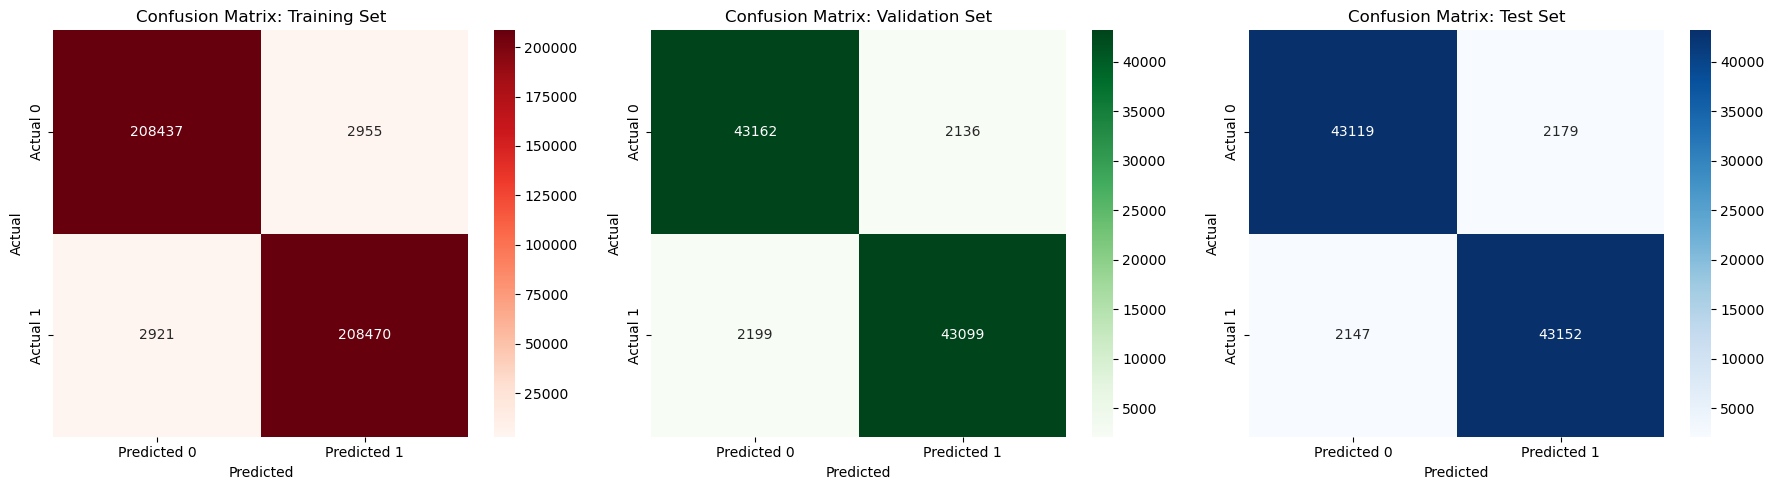

Confusion Matrix: Test Set
          Predicted 0  Predicted 1
Actual 0        43119         2179
Actual 1         2147        43152
Accuracy Score: 0.9522500745057784
Classification Report: Test Set
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     45298
           1       0.95      0.95      0.95     45299

    accuracy                           0.95     90597
   macro avg       0.95      0.95      0.95     90597
weighted avg       0.95      0.95      0.95     90597



In [20]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create confusion matrix dataframes
cm_train_df = pd.DataFrame(cm_train, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
cm_val_df = pd.DataFrame(cm_val, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
cm_test_df = pd.DataFrame(cm_test, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Display confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cm_train_df, annot=True, fmt="d", cmap="Reds", ax=axes[0])
axes[0].set_title("Confusion Matrix: Training Set")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_val_df, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Confusion Matrix: Validation Set")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

sns.heatmap(cm_test_df, annot=True, fmt="d", cmap="Blues", ax=axes[2])
axes[2].set_title("Confusion Matrix: Test Set")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Displaying results
print("Confusion Matrix: Test Set")
print(cm_test_df)
print(f"Accuracy Score: {test_acc_score}")
print("Classification Report: Test Set")
print(classification_report(y_test, test_predictions))

#### 5.2.5. Feature Importance

In [21]:
# Random Forests in sklearn will automatically calculate feature importance
importances = best_rf_model.feature_importances_
# We can sort the features by their importance
sorted_importances = sorted(zip(importances, X.columns), reverse=True)

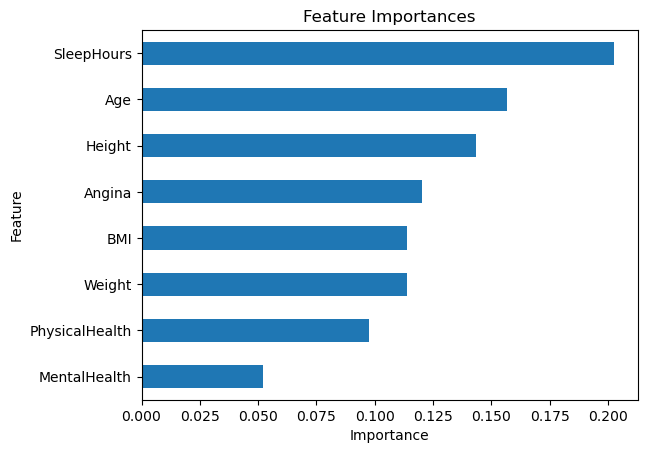

In [22]:
# Create a DataFrame for the importances
importances_df = pd.DataFrame(sorted_importances, columns=['Importance', 'Feature'])
importances_df.set_index('Feature', inplace=True)
importances_sorted = importances_df.sort_values(by='Importance')

# Plot the feature importances
importances_sorted.plot(kind='barh', title='Feature Importances', legend=False)
plt.xlabel('Importance')
plt.show()
